In [2]:
import json
from sklearn.utils import shuffle
import librosa
import numpy as np
from scipy.signal import resample
import os
import glob
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn.utils.rnn import pad_sequence

In [3]:
def pad_and_split_audio(y, sr, target_length=8, interval_length=0.05):
    # Pad the audio to 8 seconds
    target_samples = target_length * sr
    if len(y) < target_samples:
        y = np.pad(y, (0, target_samples - len(y)), mode='constant')
    else:
        y = y[:target_samples]

    # Split the audio into 0.05-second intervals
    interval_samples = int(sr * interval_length)
    intervals = [y[i:i + interval_samples] for i in range(0, len(y), interval_samples)]
    
    return intervals

In [4]:

def load_audio_files_and_labels(json_path, audio_dir, sr=8000, target_length=8, interval_length=0.05):
    with open(json_path, 'r') as f:
        annotations = json.load(f)

    audio_sequences = []
    sequence_labels = []

    # Create a dictionary to map the first 47 characters of the file names to the full file names
    audio_file_dict = {}
    for file_name in os.listdir(audio_dir):
        if file_name.endswith('.wav'):
            base_name = file_name[:47]
            audio_file_dict[base_name] = file_name

    for audio_base_name, intervals_labels in annotations.items():
        if audio_base_name in audio_file_dict:
            audio_file_path = os.path.join(audio_dir, audio_file_dict[audio_base_name])
            y, sr = librosa.load(audio_file_path, sr=sr)
            intervals = pad_and_split_audio(y, sr, target_length, interval_length)

            interval_labels = []
            for i, interval in enumerate(intervals):
                interval_start = i * interval_length
                interval_end = interval_start + interval_length
                interval_label = 0  # Default label
                
                for label_start, label_end, label in intervals_labels:
                    if label_start <= interval_start < label_end:
                        interval_label = label
                        break
                
                interval_labels.append(interval_label)
            
            audio_sequences.append(intervals)
            sequence_labels.append(interval_labels)
        else:
            print(f"Audio file for {audio_base_name} not found")

    return audio_sequences, sequence_labels

def load_negative_samples(negative_audio_dir, sr=8000, target_length=8, interval_length=0.05):
    audio_sequences = []
    sequence_labels = []
    
    for file_name in os.listdir(negative_audio_dir):
        if file_name.endswith('.wav'):
            audio_file_path = os.path.join(negative_audio_dir, file_name)
            y, sr = librosa.load(audio_file_path, sr=sr)
            intervals = pad_and_split_audio(y, sr, target_length, interval_length)
            
            interval_labels = [0] * len(intervals)  # All labels are 0 for negative samples
            
            audio_sequences.append(intervals)
            sequence_labels.append(interval_labels)
    
    return audio_sequences, sequence_labels

audio_dir = '/home/saadeldine.eletter/Baby_Cry/prj/our_Dataset_cry/'
json_path = 'combined_annotations_Approach5.json'
audio_sequences, sequence_labels = load_audio_files_and_labels(json_path, audio_dir)
print("Original Data Loaded Successfully!")


# Load negative samples
negative_audio_dir = '/home/saadeldine.eletter/Baby_Cry/prj/araf/'  
negative_audio_sequences, negative_sequence_labels = load_negative_samples(negative_audio_dir)
print("Negative Data Loaded Successfully!")

# Concatenate positive and negative samples
audio_sequences.extend(negative_audio_sequences)
sequence_labels.extend(negative_sequence_labels)

# Shuffle the data
audio_sequences, sequence_labels = shuffle(audio_sequences, sequence_labels, random_state=42)

print("Data is Concatenated and Shuffled Successfully!")

Original Data Loaded Successfully!
Negative Data Loaded Successfully!
Data is Concatenated and Shuffled Successfully!


Features Extracted Successfully!


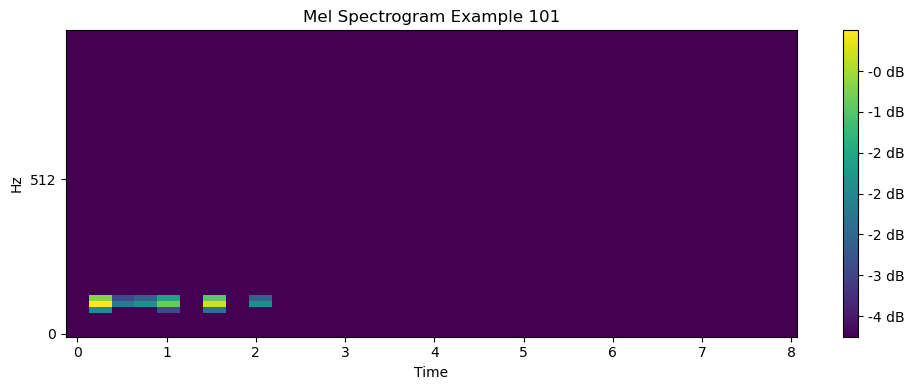

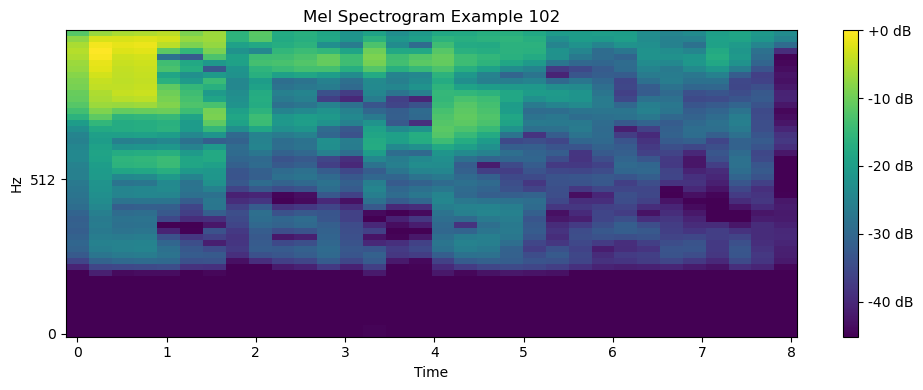

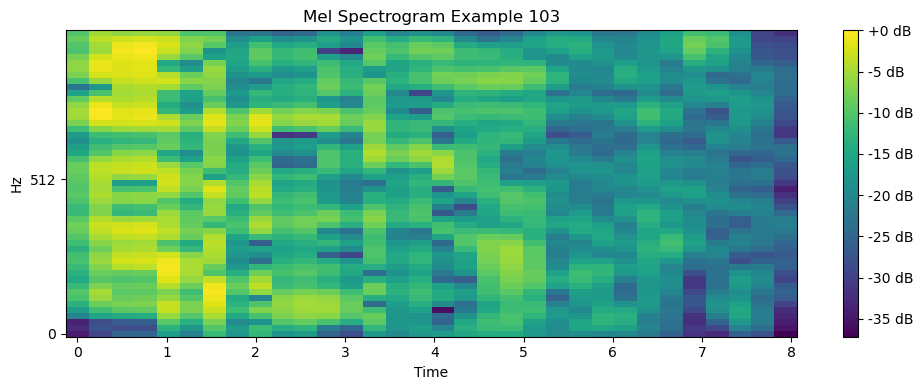

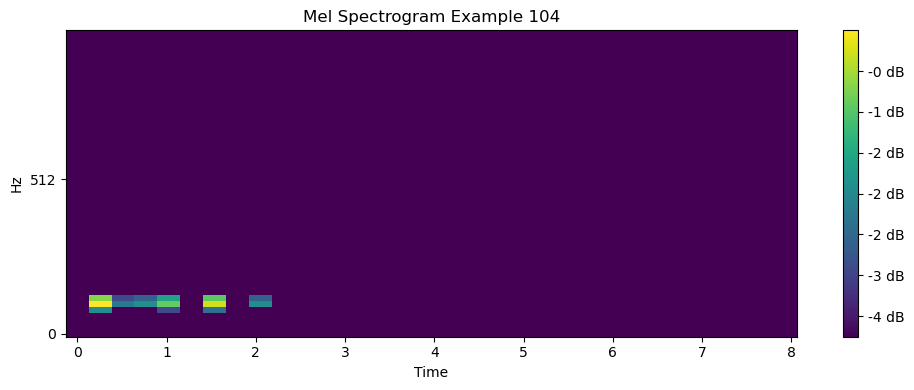

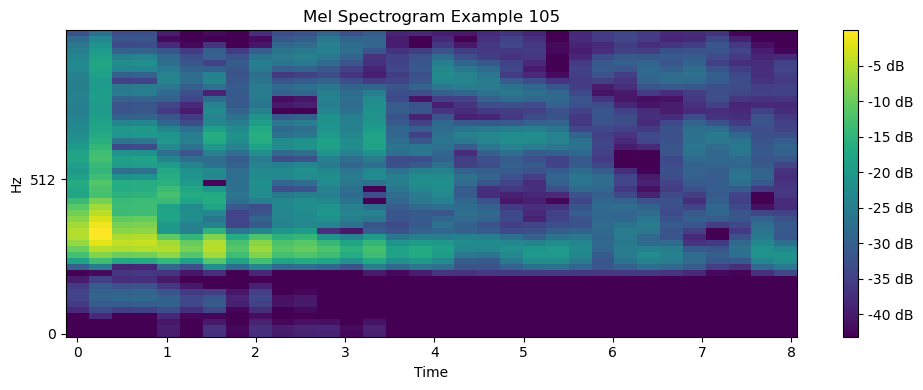

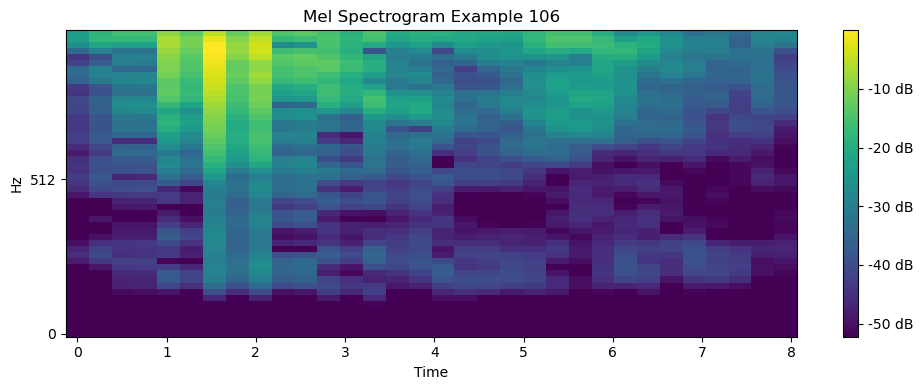

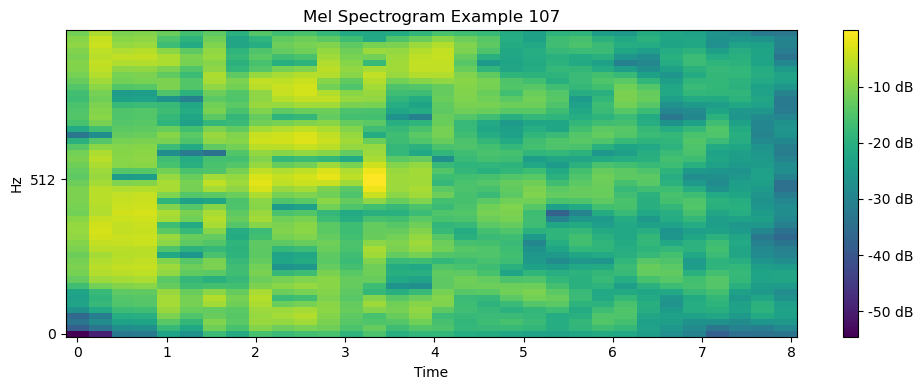

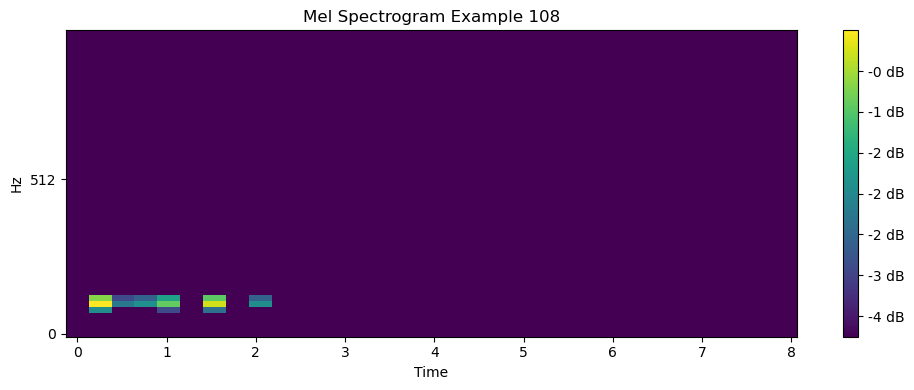

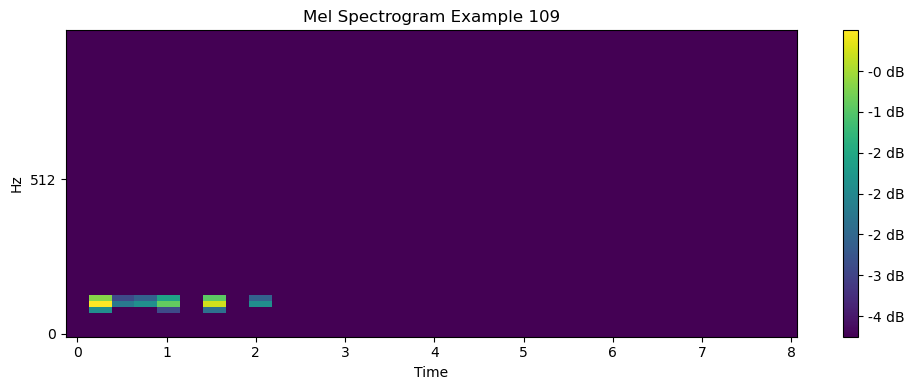

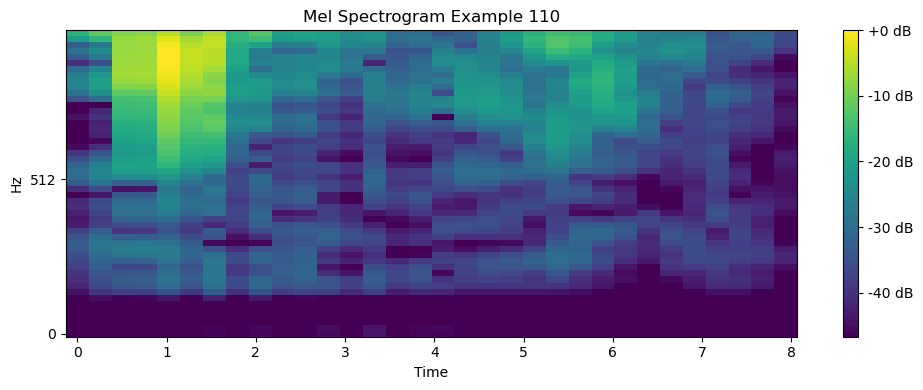

In [5]:
def extract_mel_spectrograms(audio_sequences, sr=8000, n_mels=32, n_fft=64, hop_length=8):
    feature_sequences = []
    for sequence in audio_sequences:
        features = []
        for y in sequence:
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
            log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
            features.append(log_mel_spectrogram.T)
        feature_sequences.append(features)
    return feature_sequences

feature_sequences = extract_mel_spectrograms(audio_sequences)
print("Features Extracted Successfully!")

def plot_spectrogram(spectrogram, title="Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=2000, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot the first few spectrograms from the first interval of each sequence
for i in range(100, 110):
    if i < len(feature_sequences):
        if len(feature_sequences[i]) > 0:
            plot_spectrogram(feature_sequences[i][0], title=f"Mel Spectrogram Example {i+1}")
        else:
            print(f"Sequence {i+1} has no intervals.")
    else:
        break

In [6]:
class CrySequenceDataset(Dataset):
    def __init__(self, feature_sequences, sequence_labels, max_len=160):
        self.feature_sequences = feature_sequences
        self.sequence_labels = sequence_labels
        self.max_len = max_len

    def __len__(self):
        return len(self.feature_sequences)

    def __getitem__(self, idx):
        feature_sequence = self.feature_sequences[idx]
        label_sequence = self.sequence_labels[idx]

        # Pad or truncate each feature sequence to max_len
        padded_features = []
        for feature in feature_sequence:
            if feature.shape[0] < self.max_len:
                pad_width = self.max_len - feature.shape[0]
                feature = np.pad(feature, ((0, pad_width), (0, 0)), mode='constant')
            else:
                feature = feature[:self.max_len, :]
            padded_features.append(feature)

        padded_features = np.array(padded_features)
        feature_tensor = torch.tensor(padded_features, dtype=torch.float32)
        label_tensor = torch.tensor(label_sequence, dtype=torch.long)
        return feature_tensor, label_tensor

# Convert labels to integers
mapped_sequence_labels = [list(map(int, labels)) for labels in sequence_labels]

# Instantiate the dataset
dataset = CrySequenceDataset(feature_sequences, mapped_sequence_labels, max_len=160)

# Print dataset details
print(f"Total number of samples: {len(dataset)}")
print(f"Unique labels: {set(label for labels in sequence_labels for label in labels)}")


Total number of samples: 468
Unique labels: {0, 1}


In [7]:
# Split the dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

def collate_fn(batch):
    feature_sequences, label_sequences = zip(*batch)
    padded_feature_sequences = pad_sequence([torch.tensor(f, dtype=torch.float32).clone().detach() for f in feature_sequences], batch_first=True)
    padded_label_sequences = pad_sequence([torch.tensor(l, dtype=torch.long).clone().detach() for l in label_sequences], batch_first=True)
    return padded_feature_sequences, padded_label_sequences

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

print(f"Number of batches in training set: {len(train_loader)}")
print(f"Number of batches in test set: {len(test_loader)}")


Training set size: 374
Test set size: 94
Number of batches in training set: 47
Number of batches in test set: 12


In [8]:
class ImprovedCryTransformer(nn.Module):
    def __init__(self, input_dim=32, hidden_dim=128, num_heads=4, num_layers=2):
        super(ImprovedCryTransformer, self).__init__()
        
        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1))
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.3)
        
        # Calculate the flattened dimension after convolutional layers
        self.flattened_dim = self._get_flattened_dim(input_dim)
        
        # Transformer layers for temporal feature extraction
        self.input_projection = nn.Linear(self.flattened_dim, hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, 1)

    def _get_flattened_dim(self, input_dim):
        x = torch.zeros(1, 1, 160, input_dim)  # Example input with max_len=160
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.batch_norm3(self.conv3(x)))
        x = F.max_pool2d(x, (2, 2))
        return x.view(1, -1).size(1)

    def forward(self, x):
        batch_size, num_intervals, seq_length, feature_dim = x.size()
        
        # Convolutional layers
        x = x.view(-1, 1, seq_length, feature_dim)  # (batch_size * num_intervals, 1, seq_length, feature_dim)
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.batch_norm3(self.conv3(x)))
        x = F.max_pool2d(x, (2, 2))
        x = self.dropout(x)
        
        # Flatten and project for the transformer
        x = x.view(batch_size * num_intervals, -1)
        x = self.input_projection(x).view(batch_size, num_intervals, -1)
        
        # Transformer layers
        transformer_out = self.transformer_encoder(x)
        
        # Final classification layer
        out = self.fc(transformer_out)
        out = out.squeeze(-1)  # Remove the last dimension to match the expected output shape
        return out

print("#######################################################################")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ImprovedCryTransformer(input_dim=32)
model.to(device)


#######################################################################
Using device: cuda


ImprovedCryTransformer(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (input_projection): Linear(in_features=10240, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
  

In [9]:
def train_model(model, train_loader, num_epochs=10):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    
    # Create a cosine annealing scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Move inputs and labels to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Flatten the output and labels for the loss calculation
            outputs = outputs.view(-1)
            labels = labels.view(-1).float()  # Convert labels to float for BCEWithLogitsLoss
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Debugging prints
            print(f'Outputs: {outputs[:10]}')  # Print first 10 outputs
            print(f'Labels: {labels[:10]}')  # Print first 10 labels
            print(f'Loss: {loss.item()}')  # Print loss
            
        # Update the learning rate
        scheduler.step()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, LR: {scheduler.get_last_lr()[0]}')

# Training the model
train_model(model, train_loader)

/tmp/ipykernel_1380768/3527980976.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_feature_sequences = pad_sequence([torch.tensor(f, dtype=torch.float32).clone().detach() for f in feature_sequences], batch_first=True)
/tmp/ipykernel_1380768/3527980976.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_label_sequences = pad_sequence([torch.tensor(l, dtype=torch.long).clone().detach() for l in label_sequences], batch_first=True)


Outputs: tensor([ 0.2548,  0.1807,  0.2457, -0.0216,  0.1903,  0.2063,  0.1918,  0.0241,
         0.1004, -0.3797], device='cuda:0', grad_fn=<SliceBackward0>)
Labels: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
Loss: 0.7720159888267517
Outputs: tensor([4.1553, 4.7109, 4.7857, 5.0049, 4.9125, 4.7988, 4.9080, 5.1213, 4.8739,
        5.0565], device='cuda:0', grad_fn=<SliceBackward0>)
Labels: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
Loss: 2.723914861679077
Outputs: tensor([0.3428, 1.5341, 0.1533, 0.6549, 0.4088, 0.5397, 0.5737, 0.4763, 0.6152,
        0.6026], device='cuda:0', grad_fn=<SliceBackward0>)
Labels: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
Loss: 0.6140839457511902
Outputs: tensor([-2.9697, -3.1225, -3.0650, -3.0697, -3.1269, -3.2000, -3.1136, -2.9042,
        -2.8942, -2.9891], device='cuda:0', grad_fn=<SliceBackward0>)
Labels: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
Loss: 0.705298

In [10]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Specify the path where you want to save the model
model_save_path = 'CNN_Transformer.pth'

# Save the trained model
save_model(model, model_save_path)


Model saved to CNN_Transformer.pth


/tmp/ipykernel_1380768/3527980976.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_feature_sequences = pad_sequence([torch.tensor(f, dtype=torch.float32).clone().detach() for f in feature_sequences], batch_first=True)
/tmp/ipykernel_1380768/3527980976.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_label_sequences = pad_sequence([torch.tensor(l, dtype=torch.long).clone().detach() for l in label_sequences], batch_first=True)


Accuracy: 89.86%
              precision    recall  f1-score   support

  non-crying       0.89      0.93      0.91      8414
      crying       0.91      0.85      0.88      6626

    accuracy                           0.90     15040
   macro avg       0.90      0.89      0.90     15040
weighted avg       0.90      0.90      0.90     15040



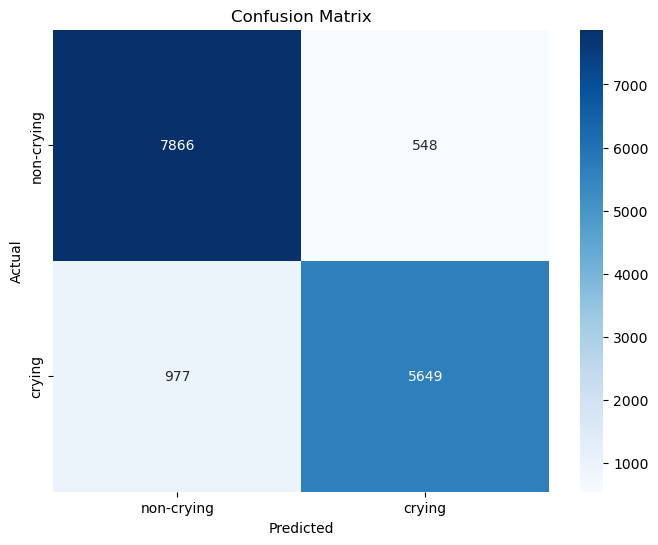

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move inputs and labels to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            outputs = outputs.view(-1)
            labels = labels.view(-1).float()  # Convert labels to float for BCEWithLogitsLoss
            
            preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
           # print(preds)
            preds = (preds > 0.5).float()  # Convert probabilities to binary predictions
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(classification_report(all_labels, all_preds, target_names=['non-crying', 'crying']))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['non-crying', 'crying'], yticklabels=['non-crying', 'crying'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluating the model
evaluate_model(model, test_loader)

tensor([0.0025, 0.0026, 0.0026, 0.0026, 0.0026, 0.0026, 0.0636, 0.0625, 0.0483,
        0.0810, 0.2761, 0.2543, 0.1190, 0.1617, 0.3798, 0.4340, 0.1870, 0.1330,
        0.0545, 0.0426, 0.0461, 0.0829, 0.1097, 0.0574, 0.4410, 0.3205, 0.0784,
        0.0678, 0.0736, 0.0188, 0.0936, 0.1411, 0.1934, 0.1512, 0.0565, 0.1341,
        0.0849, 0.0967, 0.0763, 0.1835, 0.1938, 0.1636, 0.1145, 0.1097, 0.0730,
        0.2554, 0.2136, 0.1629, 0.1018, 0.1551, 0.1267, 0.0980, 0.2007, 0.0852,
        0.1333, 0.0955, 0.2628, 0.2454, 0.1189, 0.2975, 0.1658, 0.2501, 0.0805,
        0.9256, 0.9894, 0.9205, 0.7938, 0.3841, 0.2196, 0.1728, 0.7425, 0.9437,
        0.5570, 0.7378, 0.2278, 0.0639, 0.0756, 0.0306, 0.1004, 0.0975, 0.0485,
        0.0059, 0.0931, 0.0715, 0.1279, 0.7131, 0.9820, 0.8221, 0.1713, 0.2127,
        0.0695, 0.0532, 0.0647, 0.0697, 0.1071, 0.1294, 0.4877, 0.9320, 0.8575,
        0.9397, 0.7740, 0.5291, 0.4190, 0.1065, 0.0200, 0.0403, 0.0824, 0.0667,
        0.1984, 0.0846, 0.0686, 0.0802, 

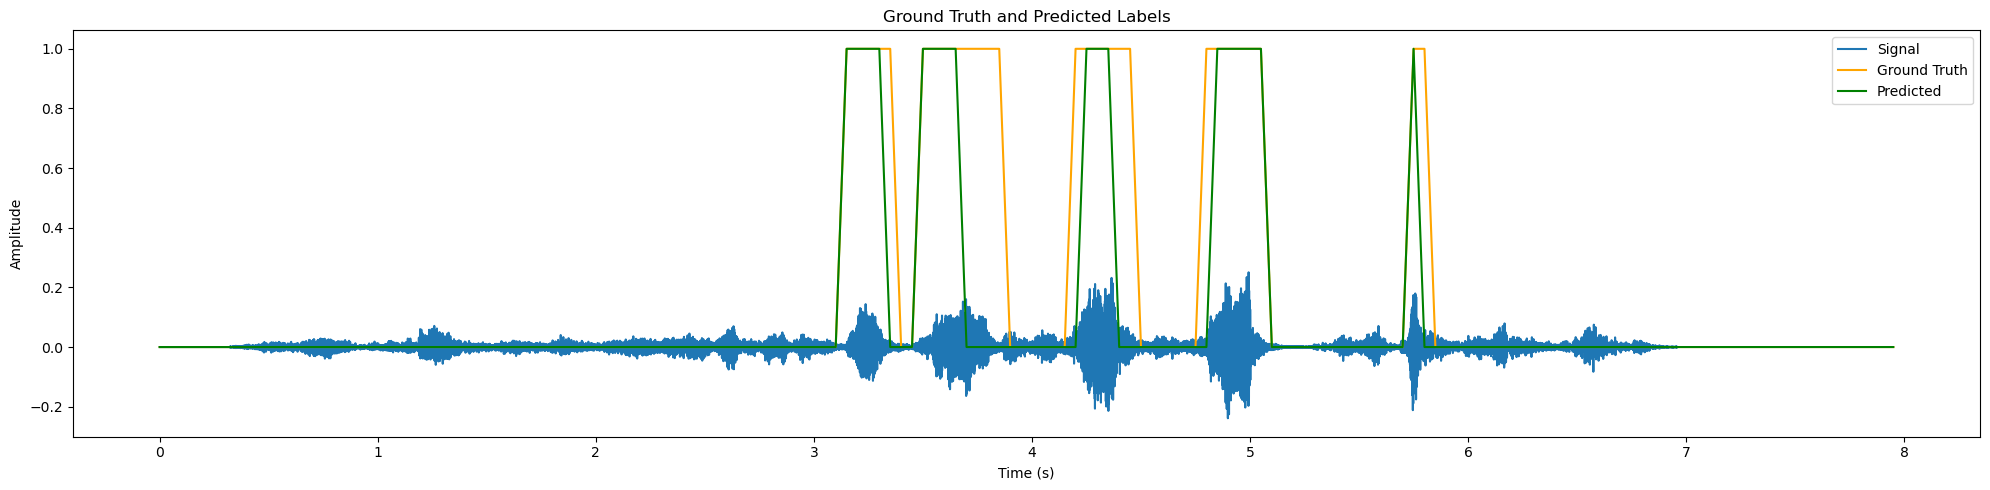

In [21]:
import matplotlib.pyplot as plt
import json
import numpy as np
import torch
import librosa
import matplotlib.pyplot as plt

# Load the JSON file with annotations
json_path = 'combined_annotations_Approach5.json'
with open(json_path, 'r') as f:
    annotations = json.load(f)

# Load and preprocess the specific audio file
audio_file_path = 'our_Dataset_cry/2a0e6a88-b049-4f46-a3d6-d73ffae470d5-1430770144865-1.7-m-04-hu.wav'
y, sr = librosa.load(audio_file_path, sr=8000)
intervals = pad_and_split_audio(y, sr, target_length=8, interval_length=0.05)

# Extract Mel spectrogram features
def extract_mel_spectrogram(y, sr=8000, n_mels=32, n_fft=64, hop_length=8):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram.T

feature_sequence = [extract_mel_spectrogram(interval, sr) for interval in intervals]

# Pad or truncate each feature sequence to max_len
max_len = 160
padded_features = []
for feature in feature_sequence:
    if feature.shape[0] < max_len:
        pad_width = max_len - feature.shape[0]
        feature = np.pad(feature, ((0, pad_width), (0, 0)), mode='constant')
    else:
        feature = feature[:max_len, :]
    padded_features.append(feature)

padded_features = np.array(padded_features)
feature_tensor = torch.tensor(padded_features, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Run the model on the preprocessed features
model.eval()
with torch.no_grad():
    feature_tensor = feature_tensor.to(device)
    outputs = model(feature_tensor)
    outputs = outputs.view(-1)
    preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
    print(preds)
    preds = (preds > 0.5).float()  # Convert probabilities to binary predictions
    predicted_labels = preds.cpu().numpy()

# Extract ground truth labels from JSON annotations
audio_base_name = os.path.basename(audio_file_path)[:47]
interval_length = 0.05
ground_truth_labels = []
if audio_base_name in annotations:
    intervals_labels = annotations[audio_base_name]
    for i in range(len(intervals)):
        interval_start = i * interval_length
        interval_end = interval_start + interval_length
        interval_label = 0  # Default label
        for label_start, label_end, label in intervals_labels:
            if label_start <= interval_start < label_end:
                interval_label = label
                break
        ground_truth_labels.append(interval_label)
else:
    ground_truth_labels = [0] * len(predicted_labels)  # Default to zeros if not found

# Plot the audio signal with ground truth and predicted labels
def plot_audio_with_labels(signal, sr, ground_truth_labels, predicted_labels, interval_length=0.05, title="Ground Truth and Predicted Labels"):
    # Time axis for the signal
    time_axis = np.arange(len(signal)) / sr
    
    # Time axis for the labels
    label_time_axis = np.arange(len(ground_truth_labels)) * interval_length
    
    plt.figure(figsize=(20, 5))
    plt.plot(time_axis, signal, label='Signal')
    plt.plot(label_time_axis, ground_truth_labels, label='Ground Truth', color='orange')
    plt.plot(label_time_axis, predicted_labels, label='Predicted', color='green')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_audio_with_labels(y, sr, ground_truth_labels, predicted_labels, interval_length=0.05)